# Trying to fix convergence issues with BRMS

## Preliminaries

In [3]:
library(brms)

Loading required package: Rcpp

Loading 'brms' package (version 2.18.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar




Generating synthetic data

In [1]:
N <- 100
M <- 2
K <- 4
J <- 3

mu <- 0
al <- matrix(c(-1, 1), ncol = 1)
Z <- matrix(rnorm(M*N, sd = .5), ncol = N)
ep_x <- matrix(rnorm(N, sd = 0.1), ncol = N)
X <- t(al) %*% Z + ep_x

U <- matrix(rnorm(K*N, sd = .2), ncol = N)
W <- sweep(U, 2, X, "+")

h_1 <- function(x) x
h_2 <- function(x) -x
f <- function(x) 3*x
eta <- rnorm(N)
S <- f(X) + h_1(Z[1, ]) + h_2(Z[2, ]) + eta
S <- matrix(S, ncol = N)

beta0 <- matrix(rep(0, J*N), ncol = N)
beta1 <- matrix(rep(2, J), ncol = 1)
ep_y <- matrix(rnorm(J * N, sd = 0.1), ncol = N)
Y <- beta0 + beta1 %*% S + ep_y

In [10]:
data <- as.data.frame(t(rbind(Z,W,Y)))
names(data) <- c("Z1", "Z2", "W1", "W2", "W3", "W4", "Y1", "Y2", "Y3")

In [11]:
data$Xm <- as.numeric(NA)

## Question

We know that the model described in the previous notebook does not work in BRMS, even when everything is linear. 
Let's go back to a simpler model. Consider, in `lavaan` syntax:
`Xm ~= W1 + W2 + W3 ; W4 ~ Xm`

The syntax suggested online:
`bf(W1 ~ 0 + mi(Xm)) + bf(W2 ~ 0 + mi(Xm)) + bf(W3 ~ 0 + mi(Xm)) + ...`
seems weird. It looks like we're telling the model that `W1` depends on `Xm`, when it's the other way around. 

Let us experiment with 
`bf(Xm|mi() ~ 0 + W1 + W2 + W3) + bf(W4 ~ 0 + mi(Xm))`
which is more intuitive

## Coding suggested by the internet

In [4]:
bform <- bf(W1 ~ 0 + mi(Xm)) + bf(W2 ~ 0 + mi(Xm)) + bf(W3 ~ 0 + mi(Xm)) + 
bf(Xm|mi() ~ 0) + bf(W4 ~ 0 + mi(Xm)) + set_rescor(FALSE) 

fit_internet <- brm(bform, data = data)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.272 seconds (Warm-up)
Chain 1:                1.942 seconds (Sampling)
Chain 1:                3.21

Warning message:
“There were 193 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 2.94, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains f

In [5]:
summary(fit_internet)

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”
Warning message:
“There were 193 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: MV(gaussian, gaussian, gaussian, gaussian, gaussian) 
  Links: mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity
         mu = identity; sigma = identity 
Formula: W1 ~ 0 + mi(Xm) 
         W2 ~ 0 + mi(Xm) 
         W3 ~ 0 + mi(Xm) 
         Xm | mi() ~ 0 
         W4 ~ 0 + mi(Xm) 
   Data: data (Number of observations: 100) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
        Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
W1_miXm    28.35     56.34   -15.57   155.17 2.72        5       31
W2_miXm    28.44     56.52   -15.64   154.82 2.73        5       31
W3_miXm    28.36     56.39   -15.63   155.17 2.72        5       24
W4_miXm    30.31     60.26   -16.61   164.57 2.72        5       29

Family Specific Parameters: 
         Estimate Est.Error l-95% CI u-95% CI Rhat Bu

In [6]:
prior_summary(fit_internet)

prior,class,coef,group,resp,dpar,nlpar,lb,ub,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,W1,,,,,default
,b,miXm,,W1,,,,,default
,b,,,W2,,,,,default
,b,miXm,,W2,,,,,default
,b,,,W3,,,,,default
,b,miXm,,W3,,,,,default
,b,,,W4,,,,,default
,b,miXm,,W4,,,,,default
"student_t(3, 0, 2.5)",sigma,,,W1,,,0,,default


In [8]:
priors_internet <- c(
    prior(normal(1, 0.0001), class = b, coef = "miXm", resp = "W1"),
    prior(normal(1, 0.0001), class = b, coef = "miXm", resp = "W2"),
    prior(normal(1, 0.0001), class = b, coef = "miXm", resp = "W3"),
    prior(normal(1, 1), class = b, coef = "miXm", resp = "W4")
)

fit_internet <- brm(bform, data = data, prior = priors_internet)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 8e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.8 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 4.801 seconds (Warm-up)
Chain 1:                1.909 seconds (Sampling)
Chain 1:                6.71 se

In [10]:
summary(fit_internet)$fixed

,Estimate,Est.Error,l-95% CI,u-95% CI,Rhat,Bulk_ESS,Tail_ESS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
W1_miXm,0.9999980,1.002203e-04,0.9998041,1.000194,1.001116,4065.079,2503.406
W2_miXm,0.9999981,9.963741e-05,0.9998111,1.000199,1.002861,4375.796,2055.922
W3_miXm,1.0000017,1.006231e-04,0.9998012,1.000196,1.000975,3977.754,2717.705
W4_miXm,1.0686334,3.299643e-02,1.0045666,1.133879,1.001036,3501.249,2913.311


In [27]:
summary(fit_internet)$spec_pars

,Estimate,Est.Error,l-95% CI,u-95% CI,Rhat,Bulk_ESS,Tail_ESS
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sigma_W1,0.1875761,0.01872066,0.1528298,0.2269862,1.000197,2238.991,2287.159
sigma_W2,0.1660965,0.01830652,0.1316406,0.2020338,1.000364,1663.100,2185.244
sigma_W3,0.2345779,0.02045738,0.1978566,0.2766174,1.000242,3262.848,3044.049
sigma_Xm,0.7391899,0.05497999,0.6415669,0.8536129,1.000941,5257.009,3207.496
sigma_W4,0.2072308,0.02013534,0.1699756,0.2484598,1.001145,2123.161,2378.776


In [12]:
cat(stancode(fit_internet))

// generated with brms 2.18.0
functions {
}
data {
  int<lower=1> N;  // total number of observations
  int<lower=1> N_W1;  // number of observations
  vector[N_W1] Y_W1;  // response variable
  int<lower=1> Ksp_W1;  // number of special effects terms
  int<lower=1> N_W2;  // number of observations
  vector[N_W2] Y_W2;  // response variable
  int<lower=1> Ksp_W2;  // number of special effects terms
  int<lower=1> N_W3;  // number of observations
  vector[N_W3] Y_W3;  // response variable
  int<lower=1> Ksp_W3;  // number of special effects terms
  int<lower=1> N_Xm;  // number of observations
  vector[N_Xm] Y_Xm;  // response variable
  int<lower=0> Nmi_Xm;  // number of missings
  int<lower=1> Jmi_Xm[Nmi_Xm];  // positions of missings
  int<lower=1> N_W4;  // number of observations
  vector[N_W4] Y_W4;  // response variable
  int<lower=1> Ksp_W4;  // number of special effects terms
  int prior_only;  // should the likelihood be ignored?
}
transformed data {
}
parameters {
  vector[Ksp

## Alternative coding

### No prior

In [15]:
bform <- bf(Xm | mi() ~ W1 + W2 + W3) + bf(W4 ~ mi(Xm)) + set_rescor(FALSE)
fit <- brm(bform, data = data)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 6.6e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.944 seconds (Warm-up)
Chain 1:                1.149 seconds (Sampling)
Chain 1:                2.09

Warning message:
“There were 1003 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 19 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 2.61, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
htt

In [17]:
cat(stancode(fit))

// generated with brms 2.18.0
functions {
}
data {
  int<lower=1> N;  // total number of observations
  int<lower=1> N_Xm;  // number of observations
  vector[N_Xm] Y_Xm;  // response variable
  int<lower=0> Nmi_Xm;  // number of missings
  int<lower=1> Jmi_Xm[Nmi_Xm];  // positions of missings
  int<lower=1> K_Xm;  // number of population-level effects
  matrix[N_Xm, K_Xm] X_Xm;  // population-level design matrix
  int<lower=1> N_W4;  // number of observations
  vector[N_W4] Y_W4;  // response variable
  int<lower=1> Ksp_W4;  // number of special effects terms
  int prior_only;  // should the likelihood be ignored?
}
transformed data {
  int Kc_Xm = K_Xm - 1;
  matrix[N_Xm, Kc_Xm] Xc_Xm;  // centered version of X_Xm without an intercept
  vector[Kc_Xm] means_X_Xm;  // column means of X_Xm before centering
  for (i in 2:K_Xm) {
    means_X_Xm[i - 1] = mean(X_Xm[, i]);
    Xc_Xm[, i - 1] = X_Xm[, i] - means_X_Xm[i - 1];
  }
}
parameters {
  vector[Nmi_Xm] Ymi_Xm;  // estimated missings


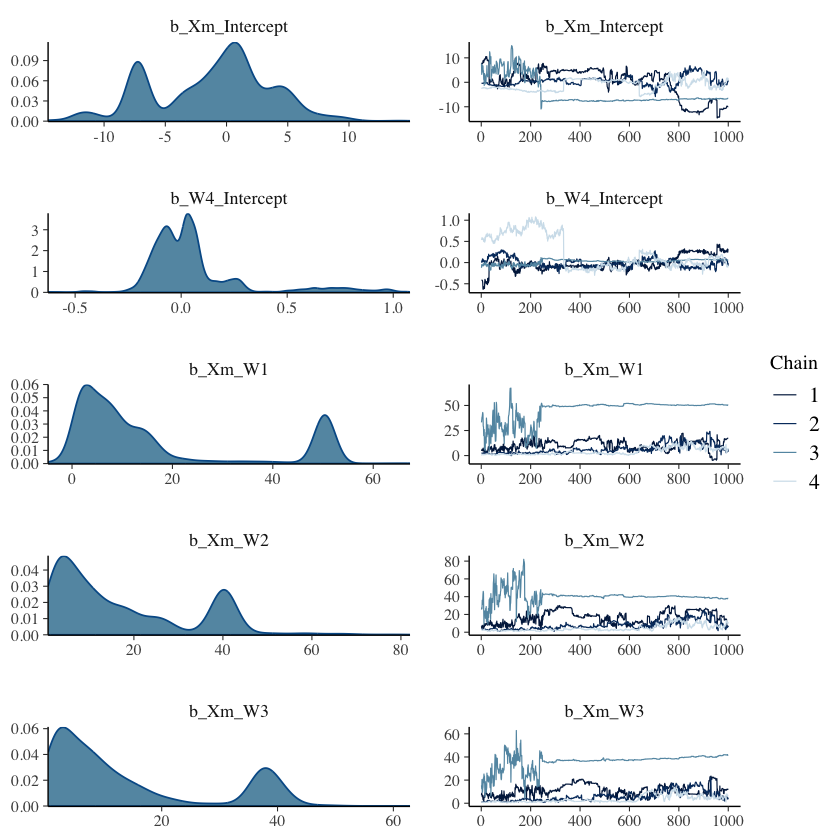

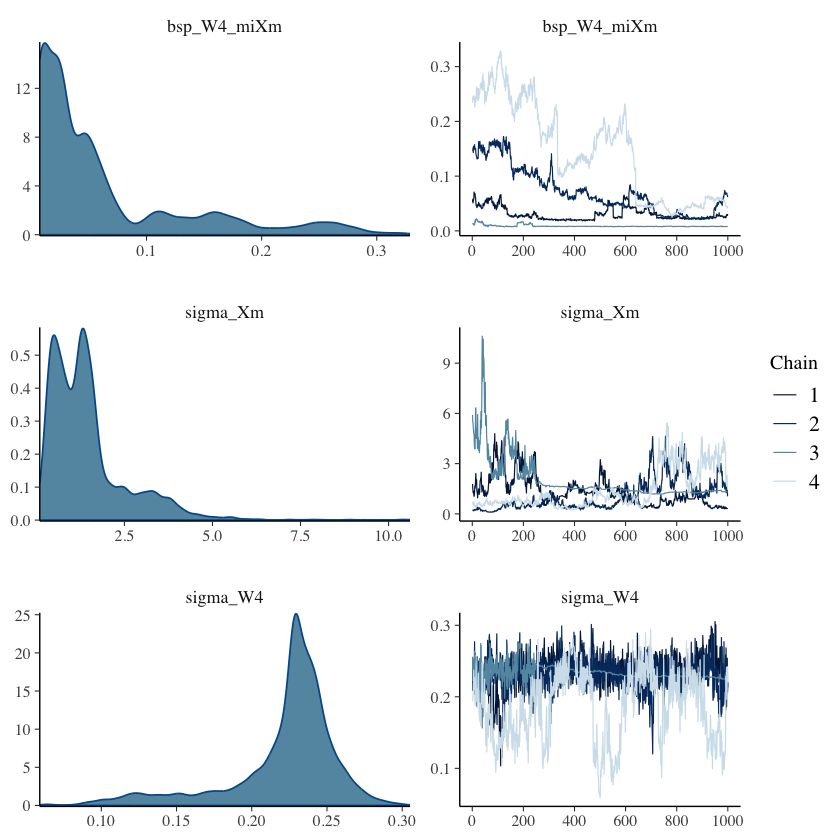

In [18]:
plot(fit)

### Priors on the regressors

In [20]:
priors <- c(
    prior(normal(1, 0.0001), coef = W1, resp = Xm),
    prior(normal(1, 0.0001), coef = W2, resp = Xm),
    prior(normal(1, 0.0001), coef = W3, resp = Xm)
    )

bform <- bf(Xm | mi() ~ 0 + W1 + W2 + W3) + bf(W4 ~ mi(Xm)) + set_rescor(FALSE)
fit <- brm(bform, data = data, prior = priors)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 6.2e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.216 seconds (Warm-up)
Chain 1:                0.719 seconds (Sampling)
Chain 1:                2.93

Warning message:
“There were 1 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.21, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for

In [21]:
summary(fit)

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”
Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: MV(gaussian, gaussian) 
  Links: mu = identity; sigma = identity
         mu = identity; sigma = identity 
Formula: Xm | mi() ~ 0 + W1 + W2 + W3 
         W4 ~ mi(Xm) 
   Data: data (Number of observations: 100) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
W4_Intercept     0.00      0.02    -0.05     0.05 1.04       97      301
Xm_W1            1.00      0.00     1.00     1.00 1.00     4043     2272
Xm_W2            1.00      0.00     1.00     1.00 1.00     3635     2466
Xm_W3            1.00      0.00     1.00     1.00 1.00     3913     2193
W4_miXm          0.35      0.01     0.33     0.37 1.03      128      191

Family Specific Parameters: 
         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma_Xm     0.48      0.20     0.09     0.77 1.16       20       73
sigma_W4     0.14      0.08     0.01 

In [24]:
prior_summary(fit)

prior,class,coef,group,resp,dpar,nlpar,lb,ub,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
"student_t(3, -0.1, 2.5)",Intercept,,,W4,,,,,default
,b,,,W4,,,,,default
,b,miXm,,W4,,,,,default
,b,,,Xm,,,,,default
"normal(1, 1e-04)",b,W1,,Xm,,,,,user
"normal(1, 1e-04)",b,W2,,Xm,,,,,user
"normal(1, 1e-04)",b,W3,,Xm,,,,,user
"student_t(3, 0, 2.5)",sigma,,,W4,,,0,,default
"student_t(3, 0, 2.5)",sigma,,,Xm,,,0,,default


### Priors on the regressors and the coefficient

In [31]:
priors <- c(
    prior(normal(1, 0.0001), coef = W1, resp = Xm),
    prior(normal(1, 0.0001), coef = W2, resp = Xm),
    prior(normal(1, 0.0001), coef = W3, resp = Xm), 
    prior(normal(1, 1), coef = miXm, resp = W4)
)

fit <- brm(bform, data = data, prior = priors)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 5.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.275 seconds (Warm-up)
Chain 1:                0.875 seconds (Sampling)
Chain 1:                3.15

Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.23, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


In [32]:
summary(fit)

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”


 Family: MV(gaussian, gaussian) 
  Links: mu = identity; sigma = identity
         mu = identity; sigma = identity 
Formula: Xm | mi() ~ 0 + W1 + W2 + W3 
         W4 ~ mi(Xm) 
   Data: data (Number of observations: 100) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
W4_Intercept    -0.00      0.02    -0.05     0.04 1.01      579      383
Xm_W1            1.00      0.00     1.00     1.00 1.00     3798     2600
Xm_W2            1.00      0.00     1.00     1.00 1.00     4069     2609
Xm_W3            1.00      0.00     1.00     1.00 1.00     3924     2639
W4_miXm          0.35      0.01     0.33     0.37 1.00      870     1788

Family Specific Parameters: 
         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma_Xm     0.46      0.19     0.06     0.73 1.23       13       30
sigma_W4     0.15      0.07     0.02 

In [14]:
cat(stancode(fit))

// generated with brms 2.18.0
functions {
}
data {
  int<lower=1> N;  // total number of observations
  int<lower=1> N_Xm;  // number of observations
  vector[N_Xm] Y_Xm;  // response variable
  int<lower=0> Nmi_Xm;  // number of missings
  int<lower=1> Jmi_Xm[Nmi_Xm];  // positions of missings
  int<lower=1> K_Xm;  // number of population-level effects
  matrix[N_Xm, K_Xm] X_Xm;  // population-level design matrix
  int<lower=1> N_W4;  // number of observations
  vector[N_W4] Y_W4;  // response variable
  int<lower=1> Ksp_W4;  // number of special effects terms
  int prior_only;  // should the likelihood be ignored?
}
transformed data {
}
parameters {
  vector[Nmi_Xm] Ymi_Xm;  // estimated missings
  vector[K_Xm] b_Xm;  // population-level effects
  real<lower=0> sigma_Xm;  // dispersion parameter
  real Intercept_W4;  // temporary intercept for centered predictors
  vector[Ksp_W4] bsp_W4;  // special effects coefficients
  real<lower=0> sigma_W4;  // dispersion parameter
}
transformed

### Adjusting the priors

In [22]:
priors <- c(
    prior(normal(.3333, 0.0001), coef = W1, resp = Xm),
    prior(normal(.3333, 0.0001), coef = W2, resp = Xm),
    prior(normal(.3333, 0.0001), coef = W3, resp = Xm)
    )

bform <- bf(Xm | mi() ~ 0 + W1 + W2 + W3) + bf(W4 ~ mi(Xm)) + set_rescor(FALSE)
fit <- brm(bform, data = data, prior = priors)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 5.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.04 seconds (Warm-up)
Chain 1:                0.881 seconds (Sampling)
Chain 1:                2.921

Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.44, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


In [23]:
summary(fit)

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”


 Family: MV(gaussian, gaussian) 
  Links: mu = identity; sigma = identity
         mu = identity; sigma = identity 
Formula: Xm | mi() ~ 0 + W1 + W2 + W3 
         W4 ~ mi(Xm) 
   Data: data (Number of observations: 100) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
W4_Intercept    -0.00      0.02    -0.05     0.04 1.01      415     1235
Xm_W1            0.33      0.00     0.33     0.33 1.00     3806     2692
Xm_W2            0.33      0.00     0.33     0.33 1.00     3853     2629
Xm_W3            0.33      0.00     0.33     0.33 1.00     3841     2555
W4_miXm          1.04      0.03     0.97     1.11 1.01      198      195

Family Specific Parameters: 
         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma_Xm     0.16      0.07     0.02     0.26 1.24       13       67
sigma_W4     0.14      0.08     0.01 

In [24]:
priors <- c(
    prior(normal(.33333, 0.0001), coef = W1, resp = Xm),
    prior(normal(.33333, 0.0001), coef = W2, resp = Xm),
    prior(normal(.33333, 0.0001), coef = W3, resp = Xm), 
    prior(normal(1, 1), coef = miXm, resp = W4)
)

fit <- brm(bform, data = data, prior = priors)

Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 5.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 2.244 seconds (Warm-up)
Chain 1:                0.848 seconds (Sampling)
Chain 1:                3.09

Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.25, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


In [25]:
summary(fit)

Warning message:
“Parts of the model have not converged (some Rhats are > 1.05). Be careful when analysing the results! We recommend running more iterations and/or setting stronger priors.”


 Family: MV(gaussian, gaussian) 
  Links: mu = identity; sigma = identity
         mu = identity; sigma = identity 
Formula: Xm | mi() ~ 0 + W1 + W2 + W3 
         W4 ~ mi(Xm) 
   Data: data (Number of observations: 100) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Population-Level Effects: 
             Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
W4_Intercept    -0.00      0.02    -0.05     0.04 1.00      308      883
Xm_W1            0.33      0.00     0.33     0.33 1.00     3931     2348
Xm_W2            0.33      0.00     0.33     0.33 1.00     3978     2983
Xm_W3            0.33      0.00     0.33     0.33 1.00     3660     2432
W4_miXm          1.04      0.03     0.98     1.11 1.03      167      138

Family Specific Parameters: 
         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma_Xm     0.16      0.07     0.01     0.25 1.19       15       23
sigma_W4     0.13      0.08     0.01 

## Conclusion

After looking at the stan code, we see that the two sintaxes encode different models. 
The more intuitive one corresponds to the model 
$$ L = \cdots \exp(- \frac{1}{2\sigma^2} \sum_{i=1}^n (x_i - \beta_1 w_{i1} - \beta_2 w_{i2} - \beta_3 w_{i3})^2) \cdots $$
The online one corresponds to the model
$$ L = \cdots \exp(- \frac{1}{2\sigma^2} \sum_{i = 1}^n (w_{i1} - \beta_1 x_{i})^2) \exp(- \frac{1}{2\sigma^2} \sum_{i = 1}^n (w_{i2} - \beta_2 x_{i})^2) \exp(- \frac{1}{2\sigma^2} \sum_{i = 1}^n (w_{i3} - \beta_3 x_{i})^2) \cdots $$

Not sure, but the second one seems correct.

Besides, the variance estimates in the first one make more sense and are more accurate

In [28]:
save(list = ls(), file = "fixing_brms.RData")

In [1]:
load("fixing_brms.RData")